In [28]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

In [15]:
train = '/mnt/newvolume/DUMP/Notebook/xray_class/data/dataset_4/train'
test = '/mnt/newvolume/DUMP/Notebook/xray_class/data/dataset_4/valid'

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [16]:
#PREPROCESSING

In [17]:
def scale_images(x, y):
    return x / 255, y

In [20]:
train_data = tf.keras.utils.image_dataset_from_directory(train, image_size=(256, 256), labels="inferred", label_mode="binary", validation_split=0.2, subset="training",seed=42)
train_data = train_data.map(scale_images)
train_size = int(len(train_data))
train_data_final = train_data.take(train_size)
print(train_size)

Found 8621 files belonging to 2 classes.
Using 6897 files for training.
216


In [21]:
val_data = tf.keras.utils.image_dataset_from_directory(train, image_size=(256, 256), labels="inferred", label_mode="binary", validation_split=0.2, subset="validation", seed=42)
val_data = val_data.map(scale_images)
val_data_final = val_data.take(len(val_data))
print(len(val_data))

Found 8621 files belonging to 2 classes.
Using 1724 files for validation.
54


In [22]:
svm_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(256, 256, 3)),
    tf.keras.layers.Dense(1, activation='linear') 
])

svm_model.compile(optimizer='adam',
                  loss='hinge',  
                  metrics=['accuracy'])

svm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 196608)            0         
                                                                 
 dense_1 (Dense)             (None, 1)                 196609    
                                                                 
Total params: 196,609
Trainable params: 196,609
Non-trainable params: 0
_________________________________________________________________


In [23]:
hist = svm_model.fit(train_data_final, epochs=10, validation_data=val_data_final)

Epoch 1/10
216/216 [==============================] - 3s 12ms/step - loss: 0.7703 - accuracy: 0.9134 - val_loss: 0.2613 - val_accuracy: 0.9588
Epoch 2/10
216/216 [==============================] - 3s 12ms/step - loss: 0.3810 - accuracy: 0.9487 - val_loss: 0.2258 - val_accuracy: 0.9693
Epoch 3/10
216/216 [==============================] - 3s 12ms/step - loss: 0.4847 - accuracy: 0.9471 - val_loss: 0.3507 - val_accuracy: 0.9623
Epoch 4/10
216/216 [==============================] - 3s 13ms/step - loss: 0.3597 - accuracy: 0.9607 - val_loss: 0.2280 - val_accuracy: 0.9664
Epoch 5/10
216/216 [==============================] - 3s 12ms/step - loss: 0.3158 - accuracy: 0.9668 - val_loss: 1.1734 - val_accuracy: 0.8927
Epoch 6/10
216/216 [==============================] - 3s 12ms/step - loss: 0.4789 - accuracy: 0.9590 - val_loss: 0.5282 - val_accuracy: 0.9553
Epoch 7/10
216/216 [==============================] - 3s 13ms/step - loss: 0.3863 - accuracy: 0.9646 - val_loss: 0.3175 - val_accuracy: 0.9687

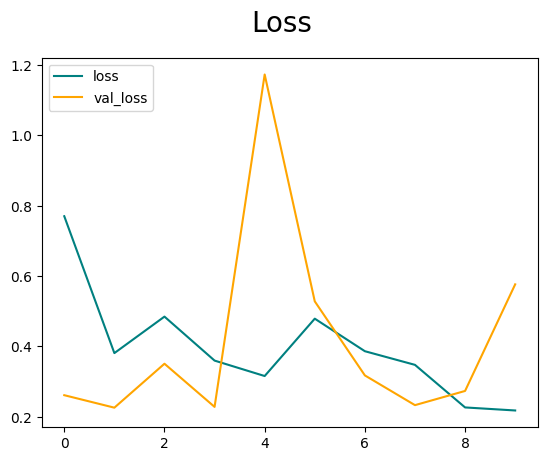

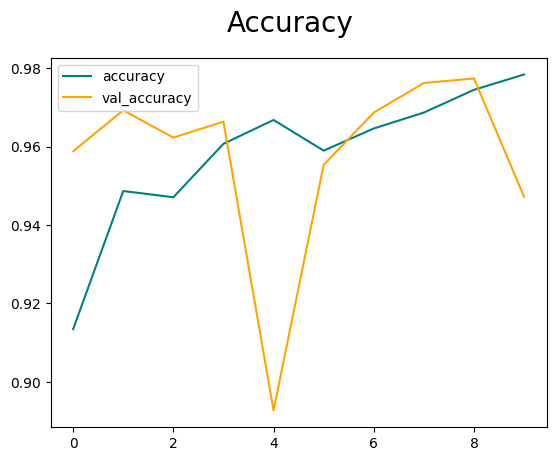

In [24]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

Found 8621 files belonging to 2 classes.
Using 1724 files for validation.
1/1 [==============================] - 0s 57ms/step


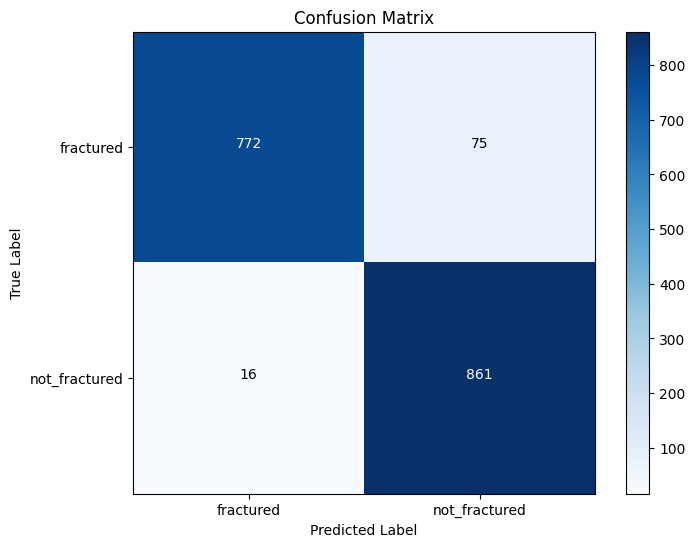

In [31]:
val_data = tf.keras.utils.image_dataset_from_directory(train, image_size=(256, 256), labels="inferred", label_mode="binary", validation_split=0.2, subset="validation", seed=42)
val_data = val_data.map(scale_images)

true_labels = []
predicted_labels = []

for batch in val_data:
    images, labels = batch
    predictions = svm_model.predict(images)
    predicted_labels.extend((predictions > threshold).astype(int))
    true_labels.extend(labels.numpy().astype(int))

confusion = confusion_matrix(true_labels, predicted_labels)

class_labels = ["not_fractured", "fractured"]

plt.figure(figsize=(8, 6))
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels)
plt.yticks(tick_marks, class_labels)

thresh = confusion.max() / 2.0
for i, j in itertools.product(range(confusion.shape[0]), range(confusion.shape[1])):
    plt.text(j, i, format(confusion[i, j], 'd'),
             horizontalalignment="center",
             color="white" if confusion[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()